In [2]:
import logging
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pathlib
from  isotools import Transcriptome
from isotools._utils import pairwise

import isotools
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools.__version__}')


INFO:This is isotools version 0.3.4


In [3]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/07_branchpoint_prediction/tables'
plot_path=f'{out_path}/07_branchpoint_prediction/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [4]:
regs=pd.read_csv(table_path+'/golong_all_2022_12_diff_3AS_all_branchpointer.csv', index_col=0)
#bpdist is the number of bases from branchpoint A to the last intron base (always positive)
#bpdist_alt is always refereing to the longer exon variant
#in contrast, as_shift is referencing to the wt prefered variant, so it may be positive or negative
#regs['bpdist_alt']+=1
#regs['bpdist']+=1

regs['bp_diff']=np.copysign(abs(regs['AS_shift'])+regs['bpdist_alt']-regs['bpdist'],regs['AS_shift'])
regs['delta_PSI']=regs['all_mut_PSI']-regs['all_wt_PSI']
regs['total_cov']=regs[[c for c in regs.columns if 'total_cov' in c]].sum(1)
#regs.loc[regs.all_wt_PSI<=.5,'splice_diff']*=-1
#regs.loc[regs.all_wt_PSI<=.5,'bp_diff']*=-1


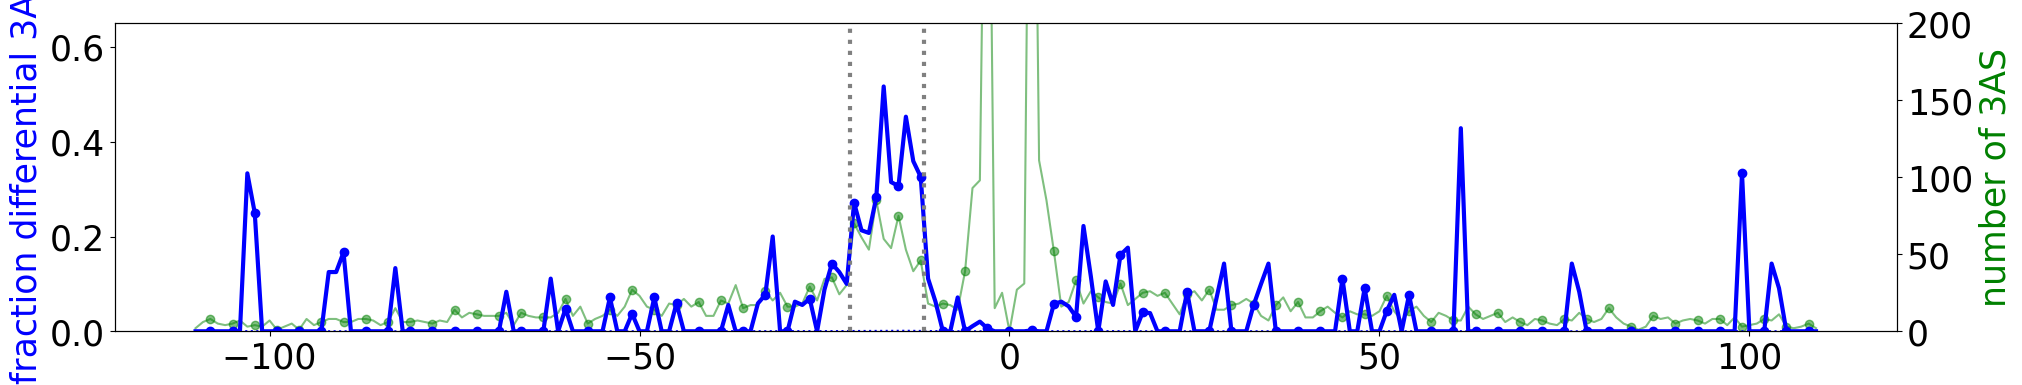

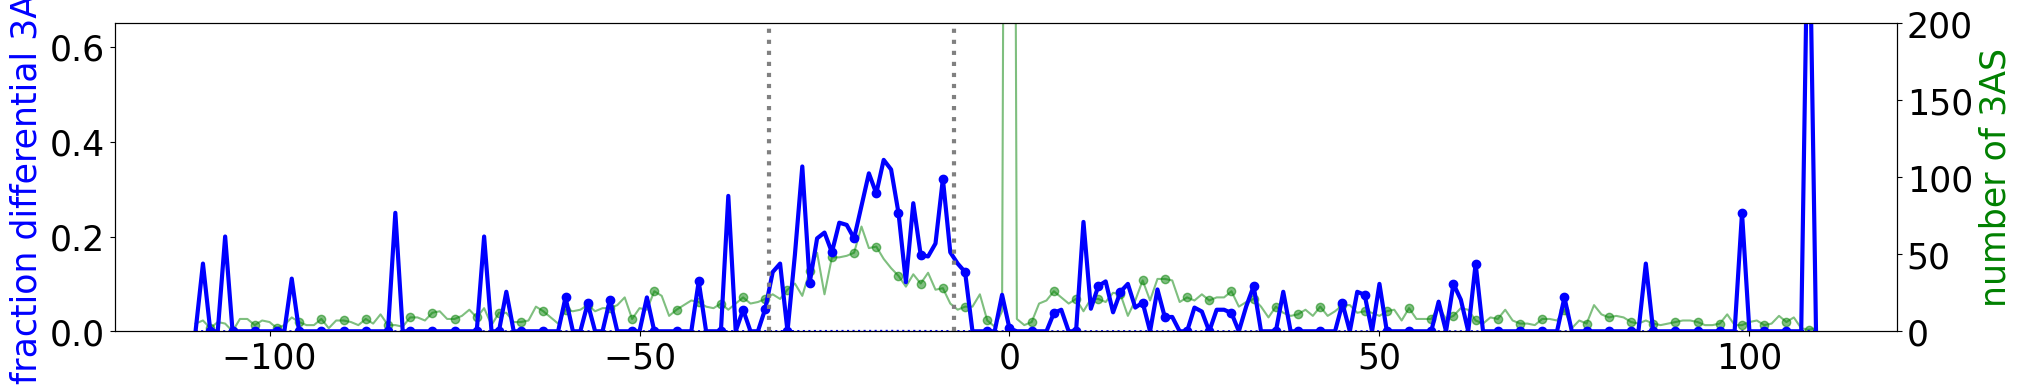

In [5]:
plt.rcParams["font.size"]=25
plt.rcParams["figure.figsize"] = (23,4)
   
tool='branchpointer'
from scipy.ndimage import gaussian_filter1d
maxd=110
mind=-110 #if sel == 'combined' else 1
for dist in ("splicesite", 'branchpoint'):
    if dist=='branchpoint':
        obs=[(sum(regs.bp_diff==d), sum((regs.bp_diff==d) & (regs.padj<.1)) ) for d in range(mind,maxd)]
    else:
        obs=[(sum(regs.AS_shift==d), sum((regs.AS_shift==d) & (regs.padj<.1)) ) for d in range(mind,maxd)]
    fig,ax=plt.subplots()
    ax.plot( range(mind,maxd),[n for n,sig in obs],'g-',alpha=.5)
    axn = ax.twinx()
    axn.plot( range(mind,maxd),[sig/n if n>0 else 0 for n,sig in obs],'b-', linewidth=3)
    axn.set_xlabel(f'{dist} distance')
    axn.set_ylabel("fraction differential 3AS", color='b')
    ax.set_ylabel("number of 3AS", color='g')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    axn.yaxis.set_label_position("left")
    axn.yaxis.tick_left()
    ax.set_ylim(0,200)
    axn.set_ylim(0,.65)
    axn.scatter(range(mind-mind%3+3,maxd,3), [sig/n if n>0 else 0 for i,(n,sig) in enumerate(obs) if i%3==2], color='b')
    ax.scatter(range(mind-mind%3+3,maxd,3), [n for i,(n,sig) in enumerate(obs) if i%3==2], color='g', alpha=0.5)
    if dist=='branchpoint':
        axn.axvline(-7.5, color="grey", ls=':', lw=3)
        axn.axvline(-32.5, color="grey", ls=':', lw=3)
    else:
        axn.axvline(-11.5, color="grey", ls=':', lw=3)
        axn.axvline(-21.5, color="grey", ls=':', lw=3)    
    ax.plot( range(mind,maxd),gaussian_filter1d([sig/n if n>0 else 0 for n,sig in obs], 2),'b:')
    #ax.set_title(sel)
    fig.savefig(f"{plot_path}/all_{dist}_enrichment_{tool}.pdf")


## what distinguishes differentially spliced 3AS?
* "sequence context" differential vs nondifferential
    * weblogos of AG, AG', BP and BP'
    * BP strength (branchpointeR)?
    * AG score (splice rover)?
    * BP == AG'? requirement that AG' may serve as BP for AG
    

sig: 191


/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new arr

nonsig: 405


/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/lienhard/.local/lib/python3.10/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new arr

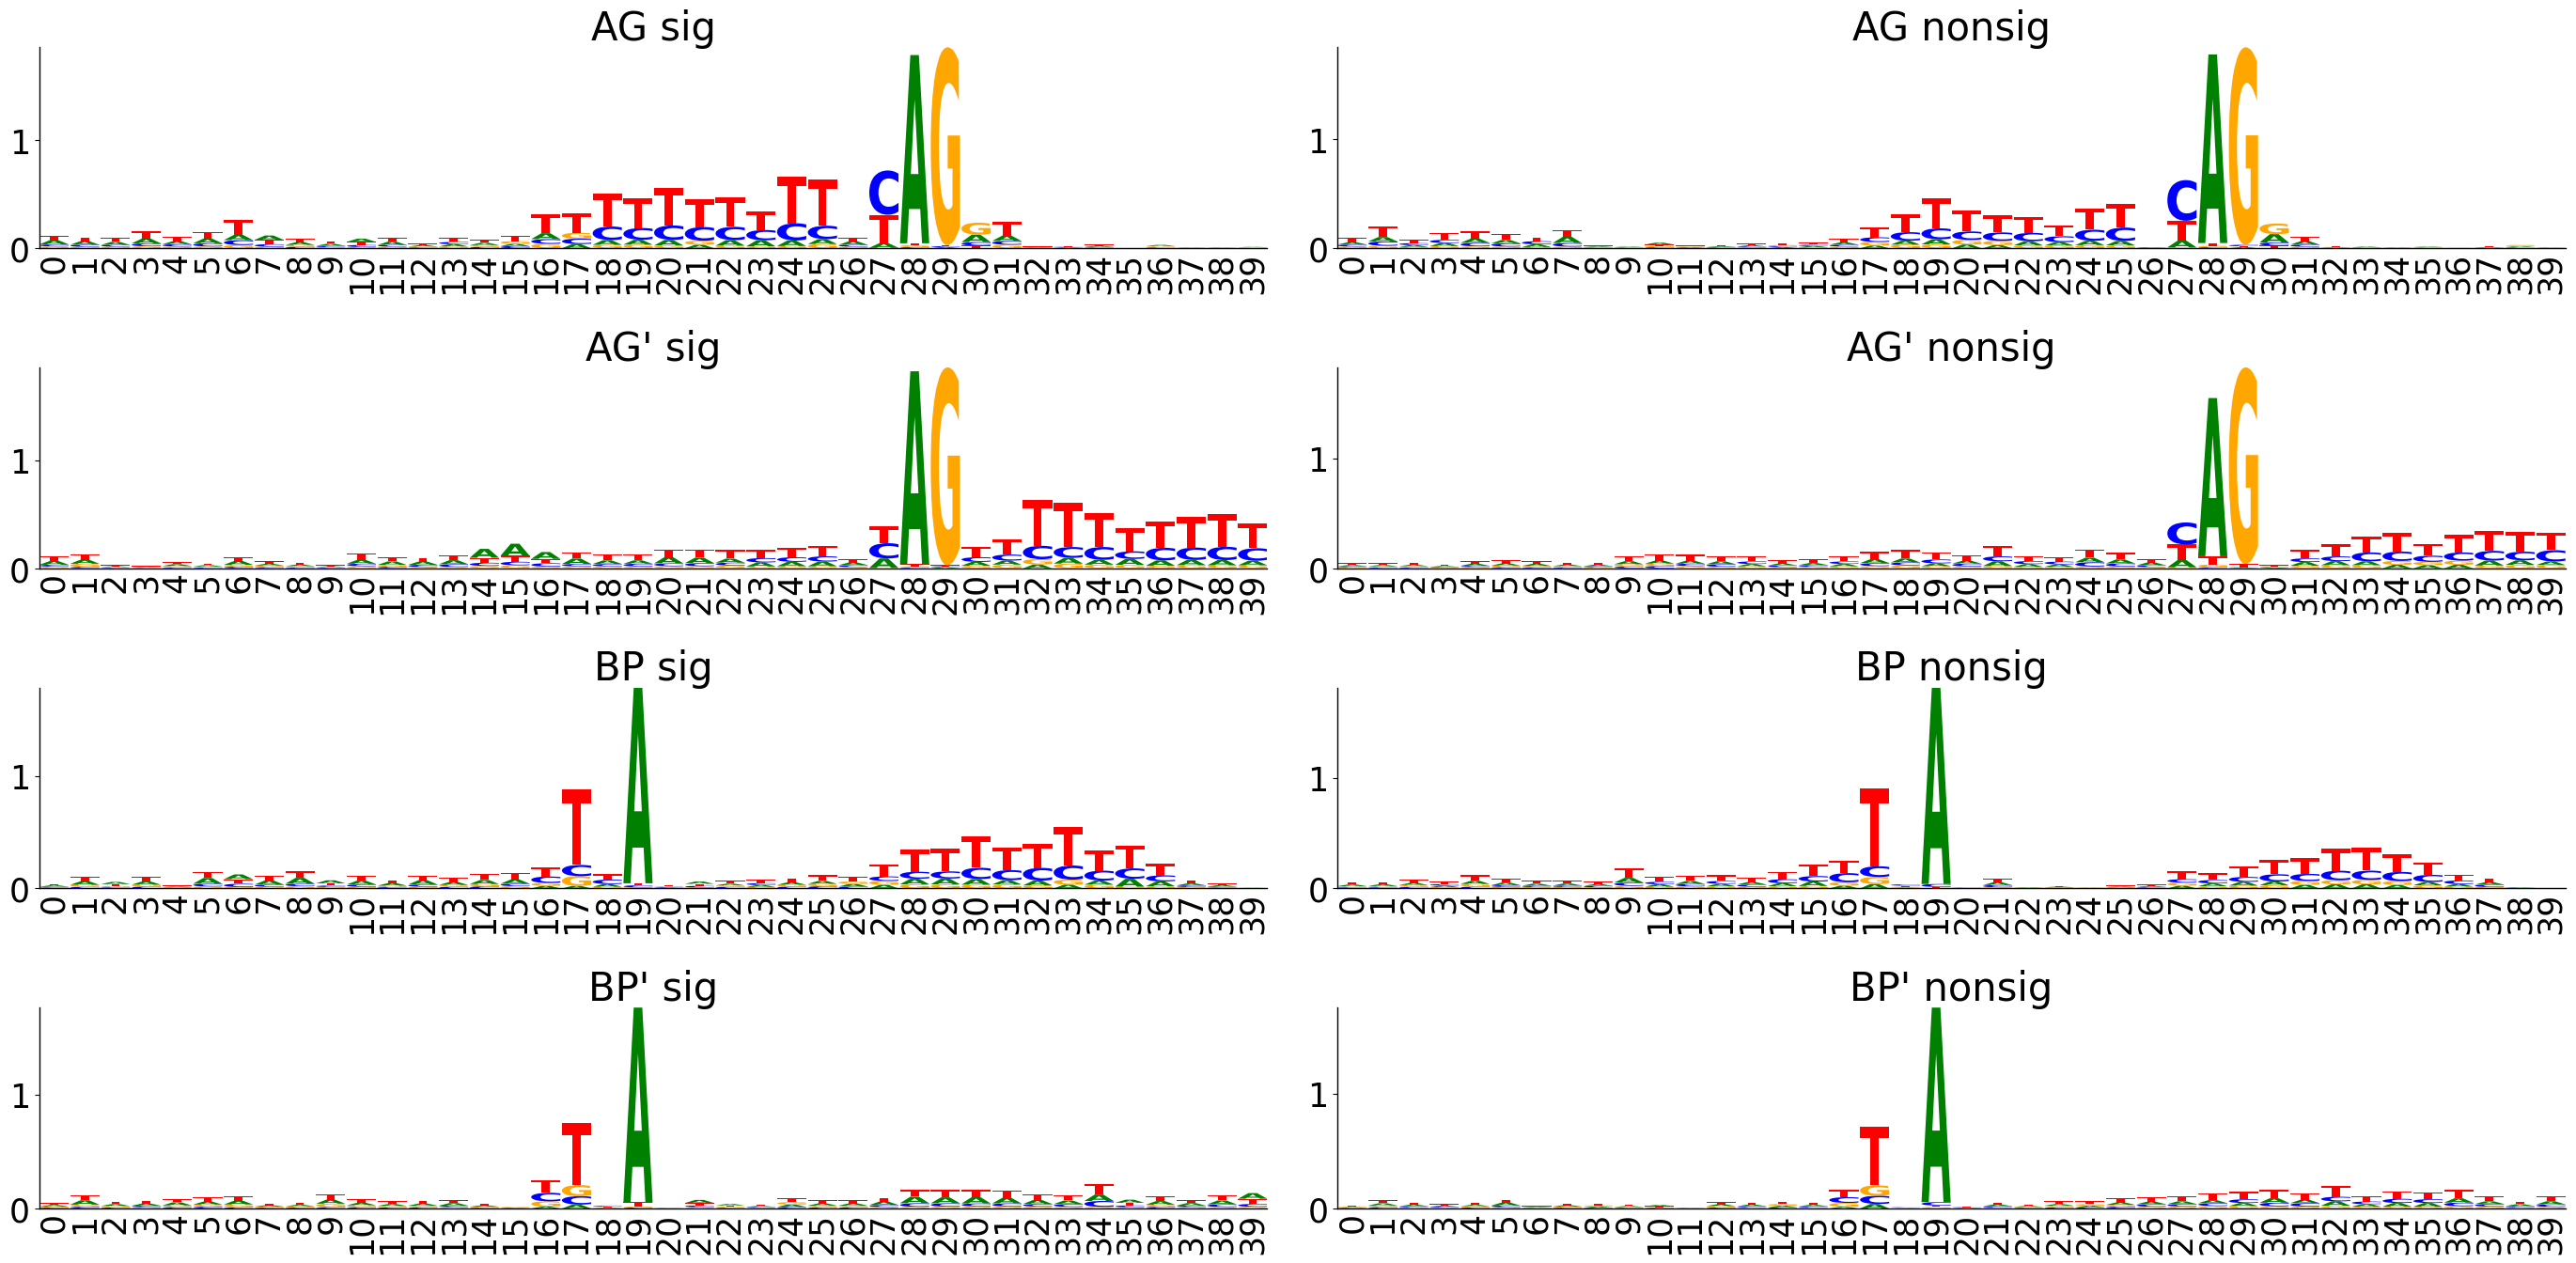

In [6]:
from IPython.display import Image
from Bio import motifs
from Bio.Seq import reverse_complement
from pysam import FastaFile
#from weblogo import SeqList, Seq, dna_alphabet
import logomaker
from PIL import Image
import io

seqs={'sig':{},'nonsig':{}}

with FastaFile(genome_fn) as genome_fh:
    for idx,row in regs.query('(-21<=AS_shift<=-12) and total_cov>100').iterrows():
        if row.strand=='+':
            ag1=genome_fh.fetch(row.chrom, row.end-30,row.end+10)
            ag2=genome_fh.fetch(row.chrom, row.alternative-30,row.alternative+10)
            bp1=genome_fh.fetch(row.chrom, row.end-row.bpdist-20,row.end-row.bpdist+20)
            bp2=genome_fh.fetch(row.chrom, row.alternative-row.bpdist_alt-20,row.alternative-row.bpdist_alt+20)
        else:            
            ag1=reverse_complement(genome_fh.fetch(row.chrom, row.start-10,row.start+30))
            ag2=reverse_complement(genome_fh.fetch(row.chrom, row.alternative-10,row.alternative+30))
            bp1=reverse_complement(genome_fh.fetch(row.chrom, row.start+row.bpdist-20,row.start+row.bpdist+20))
            bp2=reverse_complement(genome_fh.fetch(row.chrom, row.alternative+row.bpdist_alt-20,row.alternative+row.bpdist_alt+20))
        
        seqs['sig' if row.padj<.1 else 'nonsig'][idx]=(ag1,ag2,bp1,bp2)
fig, axs= plt.subplots(4,2, figsize=(28,14))
for j,what in enumerate(seqs.keys()):
    print(f"{what}: {len(seqs[what])}")
    for i,name in enumerate(['AG',"AG1","BP",'BP1']):
        
        ss_df=logomaker.alignment_to_matrix([s[i] for s in seqs[what].values()], to_type='information')
        # create Logo object
        logo = logomaker.Logo(ss_df, ax=axs[i,j])

        # style using Logo methods
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)
        logo.style_xticks(rotation=90, fmt='%d', anchor=0)

        # style using Axes methods
        #crp_logo.ax.set_ylabel("probability", labelpad=-1)
        logo.ax.xaxis.set_ticks_position('none')
        logo.ax.xaxis.set_tick_params(pad=-1)
        name2=name.replace("1","'")
        logo.ax.set_title(f"{name2} {what}")
                
        #weblogo
        #logodata = weblogo.LogoData.from_seqs(SeqList([Seq(s[i], dna_alphabet) for s in seqs[what].values()],dna_alphabet))
        #logooptions = weblogo.LogoOptions()
        #logooptions.title = name
        #logoformat = weblogo.LogoFormat(logodata, logooptions)
        #png = weblogo.png_formatter(logodata, logoformat)
        #img=Image.open(io.BytesIO(png))
        #img.save(f"{plot_path}/golong_differential_range_{what}_{name}_logo.png")
        #display(img)
fig.tight_layout()
fig.savefig(f"{plot_path}/golong_differential_range_logomaker.png")


In [7]:
# are any specific motifs enriched?

for j,what in enumerate(seqs.keys()):
    print(f"{what}: {len(seqs[what])}")
    for i,name in enumerate(['AG',"AG1","BP",'BP1']):
        if i<2:
            continue            
        print(name)
        bpseq=pd.Series(s[i][14:22] for s in seqs[what].values())
        print((bpseq.value_counts()/len(bpseq)*100).head(9))

# not really
# maybe TTTT upstream nonsignifcant BP?

sig: 191
BP
TTATTATT    1.570681
ATCTAAAT    1.570681
AGATCATG    1.047120
AAGTAATT    1.047120
GTATTACT    1.047120
CATTAATA    1.047120
ATGTCATT    1.047120
TGTTTACC    1.047120
TCCTGAAG    1.047120
dtype: float64
BP1
AGGTGAGT    1.570681
GGTTTAGC    1.570681
TTTGGAGG    1.047120
TTTTAAAA    1.047120
AGCTCACC    1.047120
TATTAATT    1.047120
CACTGATT    1.047120
GCTTTAGC    1.047120
AGTTGACA    1.047120
dtype: float64
nonsig: 405
BP
TTTTGAGA    2.222222
TTTTAATT    1.234568
TTCTCACA    0.987654
CTGTCATT    0.740741
TTTTGACA    0.740741
CTCTCCCC    0.740741
TTCTTATA    0.740741
TTCTCAGT    0.740741
TTTTAATA    0.740741
dtype: float64
BP1
AATTCACT    0.740741
GTGCCAGC    0.740741
TCTTTATT    0.740741
GATTAATA    0.740741
TCTTCATT    0.740741
TTTTGACT    0.493827
TTCTAATT    0.493827
AATATATT    0.493827
TTCTGATT    0.493827
dtype: float64


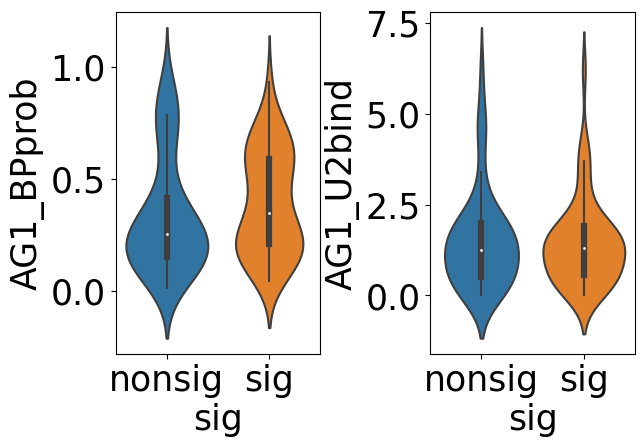

In [8]:
# is the AG' a potential BP?
import seaborn as sns
regs_sel=regs.query('(-21<=AS_shift<=-16) and total_cov>1000').copy()
regs_sel['sig']=['sig' if p<.1 else 'nonsig' for p in regs_sel.padj]
regs_sel['AG1_BPprob']=[row[f'prim_bp{row.AS_shift-2}'] for idx,row in regs_sel.iterrows()]
regs_sel['AG1_U2bind']=[row[f'prim_U2{row.AS_shift-2}'] for idx,row in regs_sel.iterrows()]
fig, axs=plt.subplots(1,2, figsize=(7,5))
sns.violinplot(data=regs_sel, y='AG1_BPprob', x='sig', ax=axs[0])
sns.violinplot(data=regs_sel, y='AG1_U2bind', x='sig', ax=axs[1])
fig.tight_layout()

(-35.0, -10.0)

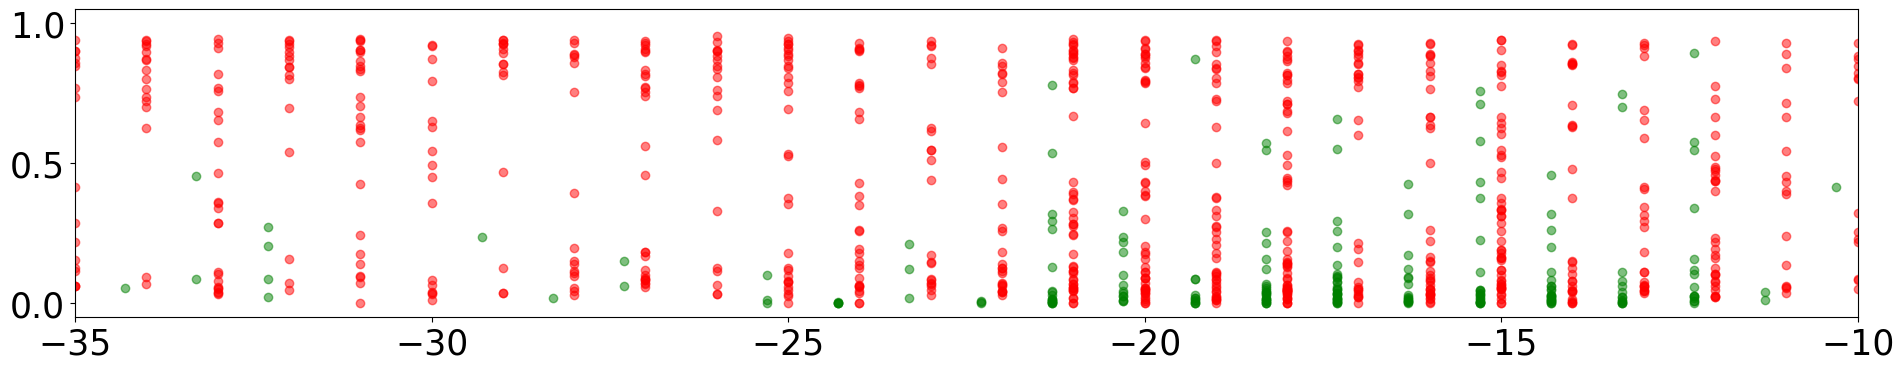

In [9]:
fig,ax=plt.subplots()
ax.scatter( regs.query('padj<.1').AS_shift-.3,regs.query('padj<.1').all_wt_PSI,color='g',alpha=.5)
ax.scatter( regs.query('padj>=.1').AS_shift,regs.query('padj>=.1').all_wt_PSI,color='r',alpha=.5)
ax.set_xlim(-35,-10)

In [10]:
#atypical cases to be invested individually
# alternative AG within -21 to -12 range
# minor usage in wt
# no incrased usage in mut
# strong expression

regs.query('padj>=.1 and all_wt_PSI<.2 and abs(delta_PSI)<.1 and -21<=AS_shift<=-12 and total_cov>1000').reset_index()
# why are they not differentially spliced?
# sequence? branchpoint?

,index,gene,gene_id,chrom,strand,start,alternative,end,NMD1,NMD2,...,alt_U2-24,alt_U2-23,alt_U2-22,alt_U2-21,alt_U2-20,alt_U2-19,alt_U2-18,bp_diff,delta_PSI,total_cov
0,2609,ABCB4,ENSG00000005471.19,chr7,-,87406494,87406515,87408036,False,False,...,1.1,0.5,3.2,0.5,0.5,0.5,0.5,-29.0,0.089724,1129
1,2636,ITCH,ENSG00000078747.16,chr20,+,34369470,34393769,34393790,False,False,...,0.7,0.7,1.6,1.9,1.2,1.2,1.8,-19.0,0.012791,1445
2,2639,PTPN4,ENSG00000088179.9,chr2,+,119877365,119877442,119877463,False,False,...,1.6,2.0,0.8,0.8,1.8,2.8,0.1,-14.0,0.025996,1328
3,2647,NPAT,ENSG00000149308.17,chr11,-,108162014,108162035,108162119,False,False,...,2.8,1.5,1.1,0.5,1.5,0.5,0.5,-22.0,0.014643,1649
4,2665,TTF2,ENSG00000116830.12,chr1,+,117076823,117077894,117077915,False,False,...,1.1,0.4,1.4,1.5,4.1,1.1,1.9,-26.0,0.011213,3388
5,2679,ADAM17,ENSG00000151694.14,chr2,-,9526244,9526264,9527785,False,False,...,0.9,0.5,2.2,2.2,2.2,2.2,1.8,-36.0,0.022758,1467
6,2692,DHX35,ENSG00000101452.15,chr20,+,38983776,38988792,38988812,False,False,...,2.4,1.5,0.1,1.2,1.1,0.4,1.1,-20.0,0.041439,2122
7,2713,HMGCS1,ENSG00000112972.15,chr5,-,43307824,43307844,43313355,False,False,...,1.9,0.5,1.1,0.6,1.3,0.6,0.6,-17.0,0.025288,1432
8,2714,DHX35,ENSG00000101452.15,chr20,+,39006356,39010259,39010279,False,True,...,1.5,2.1,2.1,1.5,2.1,2.2,3.1,-18.0,0.041850,2129
9,2740,TRAPPC11,ENSG00000168538.16,chr4,+,183705070,183706786,183706806,False,True,...,0.3,1.7,0.7,1.8,0.6,3.1,3.6,-28.0,0.020083,3259


Sequence features of differentially spliced 3AS events
Not all 3AS events with AG within -21 to -12 are differentially spliced.

* Some might be poorly expressed and thus not detectable
* Some might be strong NMD targets
* Strength of splice site?

In [11]:
import pandas as pd
from pysam import FastaFile
from Bio.Seq import Seq
# extract fasta of introns for splice rover/ Splicer
sel_regs=regs.query('(-50<=AS_shift<=50)').reset_index()
#(sel_regs.padj<.1).value_counts()
context=400
file_idx=1
total_len=0
genome_file='/project/42/pacbio/references/gencode/GRCh38.p13.genome.fa'
with FastaFile(genome_file) as genome_fh:
    outfile=open(f"{table_path}/golong_all_3AS_{context}_{file_idx:03}.fa", "w")
    for idx,row in sel_regs.iterrows():        
            seqid='>'+'_'.join(str(row[c]) for c in ['gene','chrom','strand','start','alternative','end'])
            #start,end=row.start, row.end #whole intron
            start, end=(row.alternative, row.end) if row.strand=='+' else (row.start, row.alternative)
            seq=Seq(genome_fh.fetch(row.chrom, start-context, end+context))
            total_len+=(len(seq)+len(seqid))
            if total_len>200000:
                file_idx+=1
                total_len=0
                outfile.close()
                outfile=open(f"{table_path}/golong_all_3AS_{context}_{file_idx:03}.fa", "w")
            
            print(seqid, file=outfile)
            if row.strand=='-':
                print(seq.reverse_complement(), file=outfile)
            else:
                print(seq, file=outfile)
    outfile.close()

In [50]:
# load splice rover results
def to_float(val):
    try:
        return float(val)
    except TypeError:
        return 0
scores=[]
offset=0
splice_rover=[]
for file_idx in range(16):
    splice_rover.append(pd.read_csv(f"{table_path}/golong_all_3AS_{context}_{file_idx+1:03}_splicerover.csv", header=None).set_axis(['id','pos','seq','score'],axis=1))
    splice_rover[-1].id+=offset
    offset=max(splice_rover[-1].id)+1
splice_rover=pd.concat(splice_rover, ignore_index=True)
splice_rover_pos=[]
for idx, row in sel_regs.iterrows():
    pred=splice_rover.query('id==@idx')
    start, end=(row.alternative, row.end) if row.strand=='+' else (row.start, row.alternative)
    score_i=(to_float(pred.loc[pred.pos==context-2,'score']), to_float(pred.loc[pred.pos==end-start+context-2,'score']))
    scores.append(score_i)
    if row.strand=='+':
        splice_rover_pos.extend([(row.chrom, row.alternative+(sr_pos-context+2), row.strand) for sr_pos in pred.pos])
    else:
        splice_rover_pos.extend([(row.chrom, row.alternative-(sr_pos-context+2), row.strand) for sr_pos in pred.pos])
        
result = pd.concat([sel_regs, pd.DataFrame(scores).set_axis(['splice_rover_alternative', 'splice_rover_primary'],axis=1)], axis=1)    
splice_rover_pos=pd.concat([pd.DataFrame(splice_rover_pos,columns=['chrom', 'pos', 'strand']), splice_rover.drop('pos', axis=1)], axis=1)


KeyError: "['pos'] not found in axis"

/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: >

/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 56.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/pkg/python-3.10.8-0/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 48.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


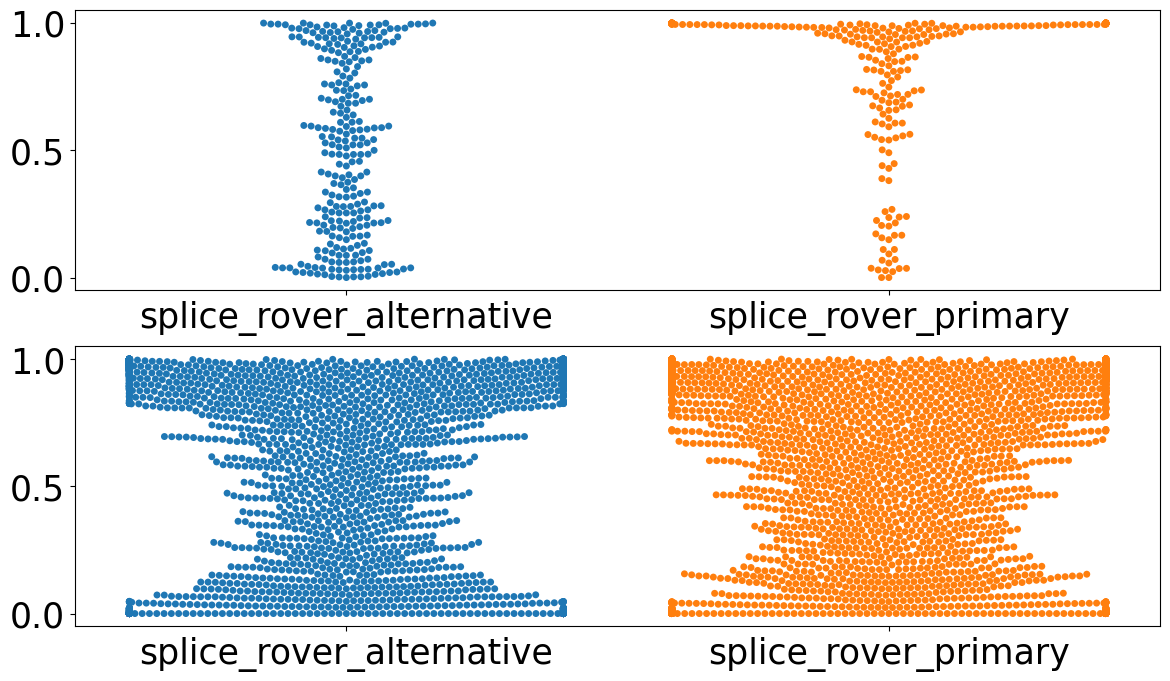

In [13]:
import seaborn as sns
sig=result.padj<.1
fig,axs=plt.subplots(2, figsize=(14,8))
sns.swarmplot(result.loc[sig,['splice_rover_alternative', 'splice_rover_primary']], ax=axs[0])
#sns.swarmplot(result.loc[~sig,['splice_rover_alternative', 'splice_rover_primary']], ax=axs[1])
# to many points

array([[ 1.        , -0.54222026],
       [-0.54222026,  1.        ]])

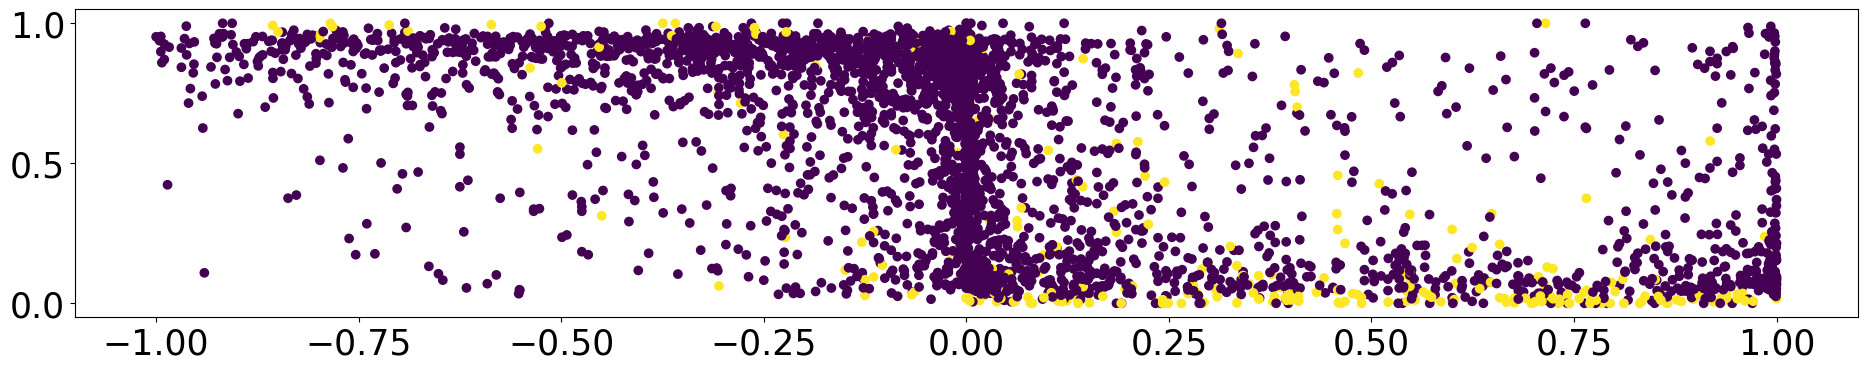

In [14]:
plt.scatter(result.splice_rover_primary-result.splice_rover_alternative, result.all_wt_PSI, c=result.padj<.1)
np.corrcoef(result.splice_rover_primary-result.splice_rover_alternative, result.all_wt_PSI)

In [57]:
# check splice_rover_pos
with FastaFile(genome_fn) as genome_fh:
    for idx,row in splice_rover_pos.iterrows():
        seq=genome_fh.fetch(row.chrom, row.pos-2, row.pos+2)
        if row.strand=='-':
            seq=reverse_complement(seq)
        assert seq[:2]=='AG'
        #print(seq)
        if idx>5000:
            break
splice_rover_pos.to_csv(f'{table_path}/{project}_{date}_3AS_all_splicerover_all_AGs.csv', index=False)


In [37]:
pd.set_option('display.max_columns', None)
cov_cols=[c for c in result.columns if '_in_cov' in c or '_total_cov' in c]
bp_cols=[c for c in result.columns if '_U2' in c or '_bp' in c]
result.to_csv(f'{table_path}/{project}_{date}_3AS_all_branchpointer_splicerover.csv', index=False)
print(len(result))
# todo: check alternative/primary
result.drop(cov_cols+bp_cols+['trA','trB'], axis=1).sort_values('pvalue').head(10)


3624


,index,gene,gene_id,chrom,strand,start,alternative,end,NMD1,NMD2,X3AS_effect,ORF_diff,AS_shift,coding,splice_type,novel,padj,pvalue,nmdA,nmdB,nmdDiff,all_mut_PSI,all_mut_disp,all_wt_PSI,all_wt_disp,total_PSI,total_disp,bpdist,bpdist_alt,bp_diff,delta_PSI,total_cov,splice_rover_alternative,splice_rover_primary
861,2897,SEPTIN6,ENSG00000125354.24,chrX,-,119625379,119625396,119629317,False,False,frame_shift,192,-17,coding,3AS,False,7.738864e-17,9.435568e-22,0.026747,0.032078,0.005331,0.443931,0.029367,0.032764,0.000030,0.241482,0.051700,21,21,-17.0,0.411167,12514,0.238765,0.812931
706,2732,MAP3K7,ENSG00000135341.18,chr6,-,90560214,90560234,90561621,False,False,frame_shift,-390,-20,coding,3AS,True,5.256039e-16,1.281680e-20,0.135329,0.191678,0.056349,0.598387,0.024815,0.099252,0.000428,0.346821,0.062682,21,39,-38.0,0.499135,4673,0.657916,0.999330
605,2628,PRPF38A,ENSG00000134748.13,chr1,+,52414647,52414740,52414761,False,False,in_frame,21,-21,coding,3AS,True,1.109617e-15,4.058685e-20,0.017446,0.014239,0.003207,0.224398,0.004776,0.030773,0.000004,0.127402,0.012174,18,28,-31.0,0.193625,6645,0.257242,0.999260
770,2800,SERBP1,ENSG00000142864.15,chr1,-,67424959,67424977,67425082,False,False,in_frame,18,-18,coding,3AS,False,4.373771e-14,2.133079e-18,0.024914,0.021690,0.003224,0.817202,0.004709,0.546292,0.001716,0.686826,0.021444,28,29,-19.0,0.270910,14891,0.896350,0.997503
2805,4941,ENOX2,ENSG00000165675.16,chrX,-,130637404,130637410,130656580,False,False,coding,6,6,coding,3AS,True,1.070160e-12,6.523933e-17,0.009105,0.005842,0.003263,0.304596,0.018294,0.787218,0.001709,0.536945,0.064457,26,20,0.0,-0.482622,4716,0.928315,0.428876
506,2528,NFYA,ENSG00000001167.14,chr6,+,41073084,41079004,41079028,False,False,UTR,0,-24,UTR,3AS,True,1.162703e-11,8.505718e-16,0.021271,0.014673,0.006598,0.219895,0.013971,0.002834,0.000043,0.102084,0.027347,30,26,-20.0,0.217061,7891,0.266125,0.996460
2912,5051,RBM18,ENSG00000119446.14,chr9,-,122261498,122261508,122264714,False,False,UTR,0,10,UTR,3AS,True,2.159568e-11,1.843129e-15,0.205607,0.341309,0.135702,0.734829,0.008714,0.961980,0.000210,0.850106,0.017929,22,19,7.0,-0.227151,3651,0.996499,0.736824
1083,3131,OXA1L,ENSG00000155463.14,chr14,+,22768171,22769776,22769790,False,False,frame_shift,-708,-14,coding,3AS,True,9.285657e-11,9.057190e-15,0.213771,0.079823,0.133948,0.420336,0.017274,0.051219,0.000005,0.232952,0.043119,26,29,-17.0,0.369117,1700,0.791613,0.987539
590,2613,SLTM,ENSG00000137776.17,chr15,-,58916999,58917020,58932355,False,False,in_frame,21,-21,coding,3AS,False,1.520795e-10,1.668799e-14,0.211047,0.226306,0.015258,0.157703,0.005676,0.016610,0.000068,0.090622,0.008503,22,24,-23.0,0.141093,13363,0.595004,0.999894
3399,5564,ANKHD1,ENSG00000131503.21,chr5,+,140436257,140438460,140438493,False,False,coding,33,33,coding,3AS,False,5.628555e-10,6.862585e-14,0.480996,0.559166,0.078170,0.649055,0.031106,0.968916,0.000394,0.805709,0.038475,24,20,29.0,-0.319861,4456,0.864162,0.641896


In [16]:
splice_rover.head() #todo: add chr and pos
#write to file

,id,pos,seq,score
0,0,208,TATGAAGATGTT,0.000383
1,0,234,TTTTTAGTTGTT,0.025377
2,0,244,TTTACAGCAGGA,0.001244
3,0,247,ACAGCAGGAGGA,0.000917
4,0,250,GCAGGAGGATCA,0.000426


## Branchpoint strength
Branchpoint strength is actually the U2 free engergy. From the branchpointer paper:
Binding energy of the eightmer surrounding the branchpoint site (-5 to +3) excluding the site to the U2 motif GUGUAGUA was calculated using Rfold from the ViennaRNA suite 


In [71]:
u2prim_cols=[c for c in result.columns if 'prim_U2' in c]
u2alt_cols=[c for c in result.columns if 'alt_U2' in c]
bpprim_cols=[c for c in result.columns if 'prim_bp' in c]
bpalt_cols=[c for c in result.columns if 'alt_bp' in c]
result['primU2_bp']=[result.loc[idx,col] for idx,col in result[bpprim_cols].idxmax(axis=1).str.replace('bp','U2').items()]
result['altU2_bp']=[result.loc[idx,col] for idx,col in result[bpalt_cols].idxmax(axis=1).str.replace('bp','U2').items()]

array([[1.        , 0.05374863],
       [0.05374863, 1.        ]])

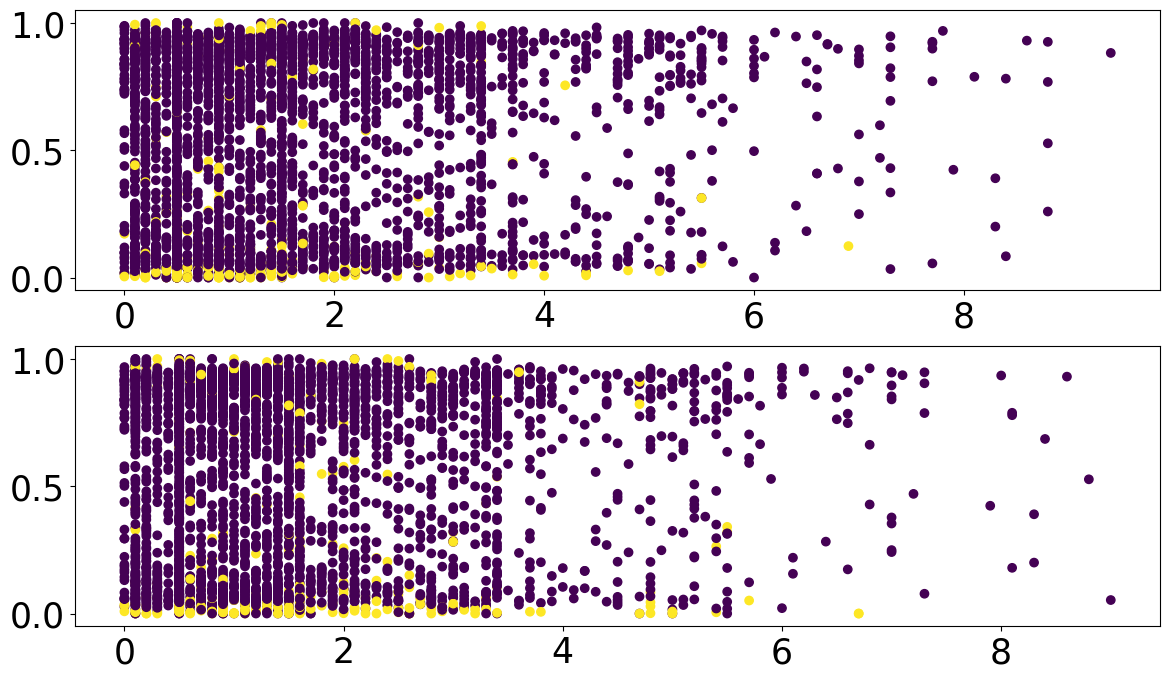

In [72]:
fig,axs=plt.subplots(2, figsize=(14,8))
axs[0].scatter(result.primU2_bp, result.all_wt_PSI, c=result.padj<.1)
axs[1].scatter(result.altU2_bp, result.all_wt_PSI, c=result.padj<.1)

np.corrcoef(result.primU2_bp, result.all_wt_PSI)

array([[1.        , 0.04410739],
       [0.04410739, 1.        ]])

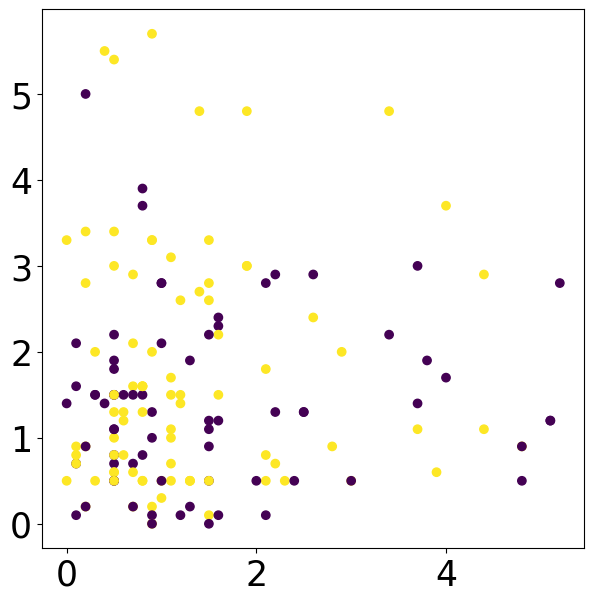

In [62]:
plt.rcParams["figure.figsize"] = (7,7)


## Characterize the range

In [39]:
range_regs=regs.query('-21<=AS_shift<=-12')
outrange_regs=regs.query('-22>AS_shift or AS_shift>-12')
print(f'{sum(range_regs.padj<.1)/len(range_regs):.2%} of 3AS within range is differential')
print(f'{sum(outrange_regs.padj<.1)/len(outrange_regs):.2%} of 3AS outside range is differential')

32.05% of 3AS within range is differential
1.77% of 3AS outside range is differential


/scratch/local/ipykernel_112807/2639780926.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(range_regs.query('padj>.1')['all_mut_PSI']-range_regs.query('padj>.1')['all_wt_PSI'])


<AxesSubplot: ylabel='Density'>

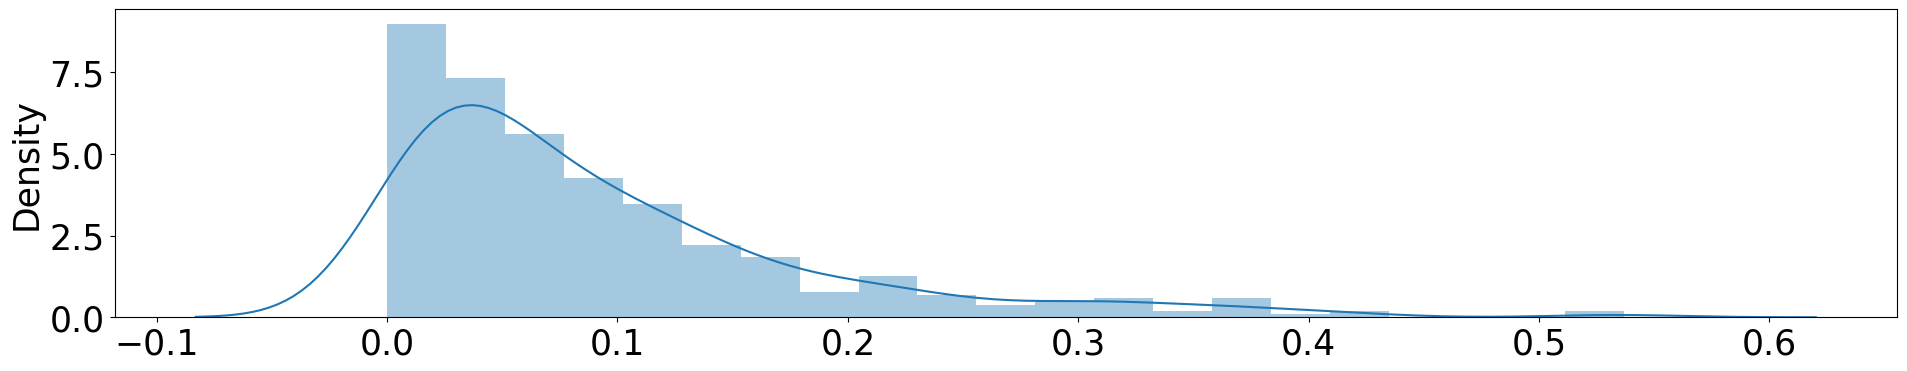

In [45]:
import seaborn as sns
sns.distplot(range_regs.query('padj>.1')['all_mut_PSI']-range_regs.query('padj>.1')['all_wt_PSI'])

-3      1
 1     43
 2      8
 3     23
 4     18
 5     21
 6     20
 7     17
 8     17
 9      6
 10     4
 11     1
 12     3
 13     4
 14     3
 15     1
 16     1
 17     1
 18     2
dtype: int64

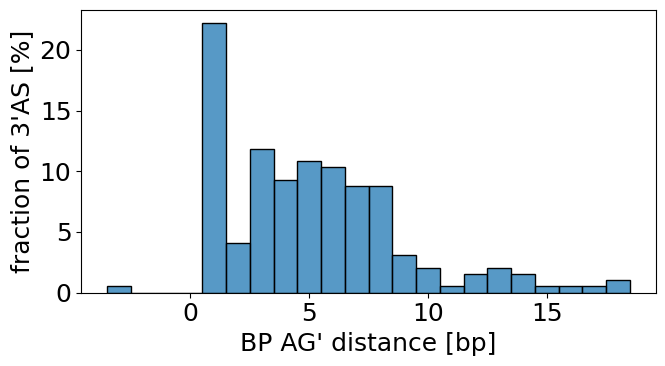

In [6]:
import seaborn as sns
plt.rcParams["font.size"]=18

plt.rcParams["figure.figsize"] = (7,4)

sig=(regs.padj<.1 ) & (regs.AS_shift>=-22)& (regs.AS_shift<=-12)
#sns.histplot([reg.bpdist[sig],reg.bpdist_alt[sig]])
ax=sns.histplot(regs.bpdist[sig]+regs.AS_shift[sig],stat='percent', bins=[i+.5 for i in range(-4,19)])
ax.set_ylabel("fraction of 3'AS [%]")
ax.set_xlabel("BP AG' distance [bp]")
plt.tight_layout()
plt.savefig(f"{plot_path}/branchpoint_agprime_dist.pdf")

(regs.bpdist[sig]+regs.AS_shift[sig]).value_counts().sort_index()

In [7]:
df=pd.DataFrame([regs.loc[sig,col] for col in ['gene', 'start','alternative','end','strand','padj','bpdist_alt','bpdist','bp_diff','AS_shift']]).T
df['dasbp']=regs.bpdist[sig]+regs.AS_shift[sig]
df[df.strand=='+'].sort_values('dasbp').head(20)


,gene,start,alternative,end,strand,padj,bpdist_alt,bpdist,bp_diff,AS_shift,dasbp
2628,PRPF38A,52414647,52414740,52414761,+,0.0,28,18,-31.0,-21,-3
2591,NET1,5455118,5456064,5456086,+,0.0,22,23,-21.0,-22,1
2766,DLST,74889349,74889877,74889896,+,0.0,17,20,-16.0,-19,1
2726,PGBD1,28281918,28283755,28283775,+,0.000001,18,21,-17.0,-20,1
2717,PSMD1,231166017,231166380,231166400,+,0.002688,30,21,-29.0,-20,1
2707,RHNO1,2877282,2885262,2885282,+,0.000287,20,21,-19.0,-20,1
2884,PRPF38B,108692867,108693571,108693589,+,0.000116,32,19,-31.0,-18,1
2912,ZNF530,57604406,57605668,57605685,+,0.065484,27,18,-26.0,-17,1
2803,ERGIC3,35556271,35556954,35556972,+,0.000066,18,19,-17.0,-18,1
2650,ZMYM4,35405468,35407986,35408007,+,0.055438,28,22,-27.0,-21,1


array([<AxesSubplot: title={'center': '+'}>,
       <AxesSubplot: title={'center': '-'}>], dtype=object)

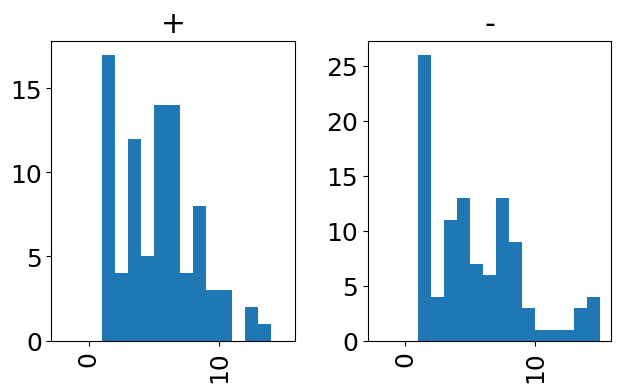

In [8]:
df.hist(column='dasbp', by='strand',  bins=range(-2,16,1))

In [9]:
df[['bpdist_alt','bpdist']].corr(numeric_only=False)

,bpdist_alt,bpdist
bpdist_alt,1.000000,-0.011309
bpdist,-0.011309,1.000000


In [10]:
isoseq=Transcriptome.load(f'{out_path}/01_transcriptome/golong_all_{date}_isotools_sparse.pkl')


INFO:loading transcriptome from /project/42/pacbio/golong/06-isotools/golong_all/results_2022_12/01_transcriptome/golong_all_2022_12_isotools_sparse.pkl


In [11]:
# define group and sample colors

groups={k:v for k,v in isoseq.groups().items() if k[:3] in ['CLL', 'MDS']}

group_dict={sa:gn for gn,sa_list in isoseq.groups().items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}

groups['CL_mut']=[sa for gr in ['K562_mut', 'Nalm6_mut'] for sa in isoseq.groups()[gr]]
groups['CL_wt']=[sa for gr in ['K562_wt', 'Nalm6_wt'] for sa in isoseq.groups()[gr]]
groups['B-cell']=isoseq.groups()['B-cell']
groups['all_mut']=[sa for grname, gr in isoseq.groups().items() if 'mut' in grname for sa in gr]
groups['all_wt']=[sa for grname, gr in isoseq.groups().items() if 'wt' in grname for sa in gr]
#groups['GM12878_ENCODE']=isoseq.groups()['GM12878']
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']

sample_colors={sa:group_colors[k] for sa in isoseq.samples for k,v in groups.items() if sa in v }
sample_colors={sa:sample_colors.get(sa,'#003C30') for sa in isoseq.samples}
sample_colors['reference']=group_colors['other']

groups_CL={k:v for k,v in groups.items() if k[:3] in ['CL_', 'GM1']}
groups_CLL={k:v for k,v in groups.items() if k in ['CLL_wt', 'CLL_mut', 'B-cell']}
groups_MDS={k:v for k,v in groups.items() if k in ['MDS_wt', 'MDS_mut', 'B-cell']}

group_same_colors={k:group_colors["all_"+k.split("_")[1]] for k in group_colors if 'wt' in k or 'mut' in k}
group_same_colors['B-cell']=group_colors['B-cell']



In [12]:
sample_num={sa:i for i,sa in enumerate(isoseq.samples)}
gr={grname: [sample_num[sa] for sa in gr] for grname, gr in groups.items()}
gr.keys()

dict_keys(['CLL_mut', 'CLL_wt', 'MDS_mut', 'MDS_wt', 'CL_mut', 'CL_wt', 'B-cell', 'all_mut', 'all_wt'])

In [16]:
from isotools._utils import pairwise
pd.set_option('display.max_rows', 250)
g=isoseq['PRPF38A']
start=52414647
canonical=52414761
alt_dict={}
for i,tr in enumerate(g.transcripts):
    for e1,e2 in pairwise(tr['exons']):
        if e1[1]==start:
            alt_dict.setdefault(e2[0],[]).append(i)
            continue
cov=np.array(tuple(g.coverage[grp,:].sum(0) for grp in gr.values()))       
frac=[]
coverage=[]
iso_names=[]

for pos, trids in alt_dict.items():
    total_cov=cov[:,trids].sum(1)
    total_frac=total_cov/cov.sum(1)
    frac.append(total_frac)
    coverage.append(total_cov)
    iso_names.append(str(pos-canonical))
    if total_cov.sum()>5:
        print(f'{pos-canonical}: {total_frac} reads; trids: {",".join(map(str,trids[:5]))} {"...("+str(len(trids))+")" if len(trids)>5 else ""}')

0: [0.78488372 0.92555995 0.73960984 0.94110115 0.7061436  0.95354239
 0.95978552 0.74209963 0.93702532] reads; trids: 0,1,2,3,5 ...(91)
-30: [0.00747508 0.00395257 0.01696353 0.00640205 0.0199852  0.00696864
 0.00536193 0.01499732 0.00537975] reads; trids: 4,10,34,54,147 
-21: [0.15863787 0.02635046 0.21119593 0.02304738 0.23390081 0.02090592
 0.0080429  0.20246385 0.02405063] reads; trids: 6,21,23,25,27 ...(15)
-12: [0.00083056 0.00065876 0.         0.         0.00444115 0.
 0.         0.00187467 0.00031646] reads; trids: 31,41 


In [15]:
pd.DataFrame(np.array(frac), index=iso_names, columns=gr.keys())*100

,CLL_mut,CLL_wt,MDS_mut,MDS_wt,CL_mut,CL_wt,B-cell,all_mut,all_wt
0,78.488372,92.555995,73.960984,94.110115,70.614360,95.354239,95.978552,74.209963,93.702532
-30,0.747508,0.395257,1.696353,0.640205,1.998520,0.696864,0.536193,1.499732,0.537975
-21,15.863787,2.635046,21.119593,2.304738,23.390081,2.090592,0.804290,20.246385,2.405063
-12,0.083056,0.065876,0.000000,0.000000,0.444115,0.000000,0.000000,0.187467,0.031646
6,0.000000,0.065876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031646
576,0.000000,0.000000,0.084818,0.000000,0.000000,0.000000,0.000000,0.026781,0.000000


In [18]:
pd.DataFrame(np.array(coverage), index=iso_names, columns=gr.keys())

,CLL_mut,CLL_wt,MDS_mut,MDS_wt,CL_mut,CL_wt,B-cell,all_mut,all_wt
0,945,1405,872,735,954,821,358,2771,2961
-30,9,6,20,5,27,6,2,56,17
-21,191,40,249,18,316,18,3,756,76
-12,1,1,0,0,6,0,0,7,1
6,0,1,0,0,0,0,0,0,1
576,0,0,1,0,0,0,0,1,0
